**1** (code cell)

In [367]:
import numpy as np
import matplotlib.pyplot as plt

**2** (code cell)

In [368]:
class Maze:
    """Represents a maze environment."""
    def __init__(self, maze, start_position, goal_position):
        """
        Create Maze object given maze configuration in the parameters and with
        start and goal positions.

        Instance Variables:
        :self.maze: numpy ndarray, Represents the layout of the maze.
        :self.maze_height: int, Represents the height of the maze
          (number of rows).
        :self.maze_width: int, Represents the width of the maze
          (number of columns).
        :self.start_position: tuple, Represents the starting position
          (row, column) in the maze.
        :self.goal_position: tuple, Represents the goal position (row, column)
          in the maze.

        Parameters:
        :param maze: numpy ndarray, Represents the layout of the maze where 0
          represents a clear path and 1 represents a wall.
        :param start_position: tuple, Represents the starting position
          (row, column) in the maze.
        :param goal_position: tuple, Represents the goal position (row, column)
          in the maze.
        """
        self.maze = maze
        self.maze_height = maze.shape[0]
        self.maze_width = maze.shape[1]
        self.start_position = start_position
        self.goal_position = goal_position

    def show_maze(self, path=None):
        """
        Displays the maze with start and goal positions marked.

        :param path: list of tuples, Represents the path taken by the agent.
        """
        plt.figure(figsize=(3,3))
        plt.imshow(self.maze, cmap='Blues')
        plt.text(self.start_position[0], self.start_position[1], 'S',
                  ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G',
                  ha='center', va='center', color='green', fontsize=20)
        if path:
            for position in path:
                plt.text(position[0]-0.1, position[1], "o", va='center',
                         color='black', fontsize=15)
        for i in range(self.maze.shape[0] + 1):
            plt.axhline(i - 0.5, color='black', linewidth=0.5)
        for j in range(self.maze.shape[1] + 1):
            plt.axvline(j - 0.5, color='black', linewidth=0.5)
        plt.xticks([]), plt.yticks([])
        plt.grid(color='black', linewidth=2)
        plt.show()

**3** (code cell)

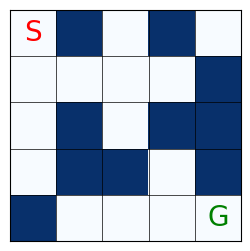

In [369]:
maze_layout = np.array([
    [0, 1, 0, 1, 0],
    [0, 0, 0, 0, 1],
    [0, 1, 0, 1, 1],
    [0, 1, 1, 0, 1],
    [1, 0, 0, 0, 0]
])

maze = Maze(maze_layout, (0, 0), (4, 4))
maze.show_maze()

**4** (code cell)

In [370]:
actions = [(-2, 0),
          (2, 0),
          (0, -2),]

**5** (code cell)

In [371]:
class QLearningAgent:
    """Represents a Q-learning agent for navigating a maze environment."""
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.5,
                 exploration_start=0.9, exploration_end=1.00,
                 num_episodes=2000):
        """
        Instance Variables:
        :self.q_table: numpy ndarray, to store Q-values
        :self.learning_rate: float, Learning rate
        :self.discount_factor: float, Discount factor for future rewards
        :self.exploration_start: float, Initial exploration rate
        :self.exploration_end: float, Final exploration rate
        :self.num_episodes: int, Number of episodes for training

        Parameters:
        :param maze: Maze
        :param learning_rate: float, Learning rate
        :param discount_factor: float, Discount factor for future rewards
        :param exploration_start: float, Initial exploration rate
        :param exploration_end: float, Final exploration rate
        :param num_episodes: int, Number of episodes for training
        """
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, len(actions)))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    def get_exploration_rate(self, current_episode):
        """
        Calculates the exploration rate for the current episode.

        :param current_episode: int, Current episode number.
        :return: float, Exploration rate for the current episode
        """
        exploration_rate = self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / self.num_episodes)
        return exploration_rate

    def get_action(self, state, current_episode):
        """
        Selects an action for the given state using epsilon-greedy strategy.

        :param state: tuple, Current state (row, column) in the maze
        :param current_episode: int, Current episode number
        :return: int, index of the selected action (0 for North, 1 for South, 2
          for West, 3 for East).
        """
        exploration_rate = self.get_exploration_rate(current_episode)
        if np.random.rand() < exploration_rate:
            return np.random.randint(len(actions))
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, next_state, reward):
        """
        Updates the Q-table based on the Q-learning algorithm.

        :param state: tuple, Current state (row, column) in the maze.
        :param action: int, Index of the action taken.
        :param next_state: tuple, Next state (row, column) in the maze.
        :param reward: float, Reward received for the action.
        """
        best_next_action = np.argmax(self.q_table[next_state])
        current_q_value = self.q_table[state][action]
        max_future_reward = self.q_table[next_state][best_next_action]
        # We use `e_d_c_r` to mean expected discounted cumulative reward
        e_d_c_r = self.learning_rate * (reward + self.discount_factor * max_future_reward - current_q_value)
        new_q_value = current_q_value + e_d_c_r
        self.q_table[state][action] = new_q_value

**6** (code cell)

In [372]:
goal_reward = 100
wall_edge_penalty = -10
step_penalty = -1

**7** (code cell)

In [373]:
def finish_episode(agent, maze, current_episode, train=True):
    """
    Simulates the agent's movements in the maze for a single episode.

    :param agent: QLearningAgent object, Q-learning agent navigating the maze.
    :param maze: Maze object, Maze environment.
    :param current_episode: int, Current episode number.
    :param train: bool, Flag to update (or not) Q-table during training
      (default=True).
    :return: tuple of three values
      - episode_reward: float, Cumulative reward obtained during the episode.
      - episode_step: int, Total number of steps taken during the episode.
      - path: list of states visited during the episode.
    """
    rows, columns = maze_layout.shape
    max_steps = rows * columns
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]

    while not is_done and episode_step < max_steps:
        action = agent.get_action(current_state, current_episode)

        next_state = (current_state[0] + actions[action][0], current_state[1]
                      + actions[action][1])

        if next_state[0] < 0 or next_state[0] >= maze.maze_height or next_state[1] < 0 or next_state[1] >= maze.maze_width or maze.maze[next_state[1]][next_state[0]] == 1:
            reward = wall_edge_penalty
            next_state = current_state
        elif next_state == maze.goal_position:
            path.append(current_state)
            reward = goal_reward
            is_done = True
        else:
            path.append(current_state)
            reward = step_penalty

        episode_reward += reward
        episode_step += 1

        if train:
            agent.update_q_table(current_state, action, next_state, reward)

        current_state = next_state

    if next_state != maze.goal_position:
        return 0, episode_step, []

    return episode_reward, episode_step, path


**8** (code cell)

In [374]:
def test_agent(agent, maze, num_episodes=1):
    """
    Evaluates the agent's performance in the maze.

    :param agent: QLearningAgent, Q-learning agent navigating the maze.
    :param maze: Maze
    :param num_episodes: int, Number of episodes to simulate (default=1).
    :return: tuple of two values, corresponding to:
      - episode_step: int, Total number of steps taken during the evaluation
      episode
      - episode_reward: float, Cumulative reward obtained during the evaluation
      episode
    """
    episode_reward, episode_step, path = finish_episode(agent, maze,
                                                        num_episodes,
                                                        train=False)
    if path == []:
      print("No path found")
    else:
      print("Learned Path:")
      for row, col in path:
          print(f"({row}, {col})-> ", end='')
      print("Goal!")

    print("Number of steps:", episode_step)
    print("Total reward:", episode_reward)

    maze.show_maze(path)

    return episode_step, episode_reward

**9** (code cell)

No path found
Number of steps: 25
Total reward: 0


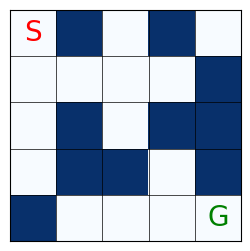

(25, 0)

In [375]:
agent = QLearningAgent(maze)
test_agent(agent, maze)

**10** (code cell)

In [376]:
def train_agent(agent, maze, num_episodes=100):
    """
    Trains the Q-learning agent to navigate the maze.

    :param agent: QLearningAgent, agent navigating the maze
    :param maze: Maze
    :param num_episodes: int, Number of episodes for training (default=100)
    """
    episode_rewards = []
    episode_steps = []

    for episode in range(num_episodes):
        episode_reward, episode_step, path = finish_episode(agent, maze,
                                                            episode,
                                                            train=True)

        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)
    if episode_reward == 0:
      print ("No path found")
    else:
      plt.figure(figsize=(10, 5))
      plt.subplot(1, 2, 1)
      plt.plot(episode_rewards)
      plt.xlabel('Episode')
      plt.ylabel('Cumulative Reward')
      plt.title('Reward per Episode')
      print(episode_rewards)
      average_reward = sum(episode_rewards) / len(episode_rewards)
      print(f"The average reward is: {average_reward}")

      plt.subplot(1, 2, 2)
      plt.plot(episode_steps)
      plt.xlabel('Episode')
      plt.ylabel('Steps Taken')
      plt.ylim(0, 100)
      plt.title('Steps per Episode')

      average_steps = sum(episode_steps) / len(episode_steps)
      print(f"The average steps is: {average_steps}")

      plt.tight_layout()
      plt.show()

#### **Training the agent**

**11** (code cell)

In [377]:
train_agent(agent, maze, num_episodes=100)

No path found


#### **Testing the agent after training**

**12** (code cell)

No path found
Number of steps: 25
Total reward: 0


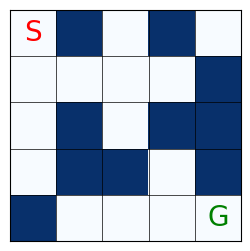

(25, 0)

In [378]:
test_agent(agent, maze, num_episodes=100)

###Observations

###Experiment 1: Experimenting with Agent Motion Dynamics
Step Size Adjustment: Modify code cell no. 4 to explore the impact of changing the number of steps the agent takes in each direction. Analyze how this modification affects learning speed and navigation efficiency.
Ans:

The  impact of changing the the number steps
before the training obervations:


No path found
Number of steps: 0
Total reward: 0

Before the training the agent path to  the goal includes many  inefficient steps, with several  unnecessary steps before reaching the goal.
The agent will try to find out all the  steps to reach the goal before the training.
The total reward gained by the agent before training was 0 agent did not achieve any outcome during exploration.

After the training obervations:
 
No path found
Number of steps: 25
Total reward: 0

After training, the agent path becomes no  route to reach goal.
The number of steps taken after training increased to 25 indicating that the training process did not improve the agent ablity to navigate .
the total reward remained at 0 after training indicating that the agent did not achieve any outcome in training process.
overall it seems that the training process was unsuccessful in improving the agent navigation ablities.

Motion Restriction: Also, modify code cell no. 4 to investigate the effects of limiting the agent to three directions instead of four. Assess how this restriction influences the learned policy and adaptability.
ans. 

Before the training observations:

No path found
Number of steps: 0
Total reward: 0

Before the training the agent path to  the goal includes some inefficient steps, such as revisiting certain steps multiple time before reaching the goal.
The agent will try to find out all the  steps to reach the goal before the training.
The total reward gained by the agent before training was 0 agent did not achieve any outcome during exploration.

After the training observations:

No path found
Number of steps: 25
Total reward: 0

After training, the agent path becomes no  route to reach goal.

The number of steps taken after training increased to 25 indicating that the training process did not improve the agent ablity to navigate.

The total reward remained at 0 after training indicating that the agent did not achieve any outcome in training process.

Befor the training the agent path included some back and front  movements between the steps which could have been caused by the restriction forcing the agent to choose the alternative paths and after the training the agent still not find any path to move  by using the all the available directions and paths  didn't fina any path to reach  the goal.





###Experiment 2: Tuning Learning Parameters
Change the values of learning_rate and discount_factor in code cell no. 5 to observe their effects on the learning process. Investigate different combinations’ impact on convergence speed and the quality of the learned policy.

ans.
learning_rate = 0.1
discount_factor = 0.5

Before the training observations:

No path found
Number of steps: 0
Total reward: 0

The agent couldn't find a path to the goal, indicating a lack of effective navigation.

The number of steps taken before training was 0, suggesting that the agent was unable to start to towards the goal
The agent did not  achieve the total reward during its exploration.

After the training observations:

No path found
Number of steps: 0
Total reward: 0

The agent couldn't find a path to the goal, indicating a lack of effective navigation.

The number of steps taken before training was increased to 25, indicating that the training process did not improve the agent ablity to navigate.
The agent did not  achieve the total after the training.
The  learning rate of 0.1 and a discount factor of 0.5 did not lead to successful learning int the agent navigation abilities.





###Experiment 3: Testing Exploration Settings
Adjust the exploration parameters (exploration_start, exploration_end, and num_episodes) in code cell no. 5 to observe changes in the agent’s behavior. Compare learning curves and the final learned policy for different exploration strategies.

ans:

High exploration start, low exploration end, number of episodes
exploration_start = 1.0
exploration_end = 0.9
num_episodes = 2000

Before the training observations:

No path found

The agent couldn't find a path to the goal, indicating a lack of effective navigation strategy.
Since no path was found, there were no recorded number of steps or total rewards before the training.



After the training observation:
No path found
Number of steps: 25
Total reward: 0

After the training the agent still not find the path to the goal.
The number of steps taken after training remained at 25 indicating that the training process did not improve the agent.
The total reward remained at 0 after trating indicating that the agent did not achieve any outcomes during the training proces.

In this The exploration strategy of starting with high exploration and gradually decreasing to low exploration did lead to successful learning and its  no improvement in the agent behavior it still did not find any path to reach the goal.



